# Implementing a simple word2vec 

In this exercise, we will implement a word2vec by using PyTorch 

## Data

We will use the Less Miserable by Victor Hugo to train word2vec. The data can be found under at `data/less-miserable.txt` or 
https://archive.org/stream/lesmiserables00135gut/lesms10.txt

### Preprocessing 


In [36]:
import nltk

nltk.download("punkt")

# Load the data
with open("../data/less-miserable.txt", "r", encoding="utf-8") as file:
    text = file.read().lower()

# Extract the main content
# Start from VOLUME I. and end at The end of Project Gutenberg
start = text.find("volume i.")
end = text.find("the end of project gutenberg")
text = text[start:end]

[nltk_data] Downloading package punkt to /home/skojaku/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
# Tokenize the data
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
raw_sentences = tokenizer.tokenize(text)

In [66]:
import re
from tqdm import tqdm
import random

# Clean the text
sentences = []
min_words = 5
for sent in tqdm(raw_sentences):
    sent = re.sub(r"[^a-z\s]", "", sent)
    sent = re.sub(r"\s+", " ", sent).strip()
    words = sent.split()
    if len(words) < min_words:
        continue

    sentences.append(words)

# Remove infrequent words
from collections import Counter

min_count = 5

word_counts = Counter()
for sent in sentences:
    word_counts.update(sent)

filtered_sentences = []
for sent in sentences:
    filtered = [word for word in sent if word_counts[word] >= min_count]
    if len(filtered) >= min_words:
        filtered_sentences.append(filtered)

# Print the number of sentences, average number of words, and print the random 3 sentences
print(f"Number of sentences: {len(filtered_sentences)}")
print(
    f"Average number of words: {sum(len(sent) for sent in filtered_sentences) / len(filtered_sentences)}"
)
print(f"Example sentence: {random.sample(filtered_sentences, 1)}")

 56%|█████▌    | 19961/35499 [00:00<00:00, 199590.20it/s]

100%|██████████| 35499/35499 [00:00<00:00, 202171.43it/s]


Number of sentences: 28832
Average number of words: 17.91138318534961
Example sentence: [['they', 'left', 'that', 'rag', 'where', 'it', 'hung', 'they', 'did', 'not', 'put', 'the', 'finishing', 'touch', 'to', 'it']]


In [67]:
# Convert the words to integers
from collections import Counter

word_counts = Counter(word for sent in filtered_sentences for word in sent)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
word_to_int = {word: ii for ii, word in enumerate(vocab)}
int_to_word = {ii: word for word, ii in word_to_int.items()}
sentences_int = [[word_to_int[word] for word in sent] for sent in filtered_sentences]

## Model & Training 


Define the word2vec model using `torch.nn.Module` . 

![](https://lh3.googleusercontent.com/proxy/70-YFG_mmT5o_IjJtK3q2ADr0IAh5uLb2TSqllAWVQ1bTEGc5HUMOgOp0rH0RpCk3W2JEhz_L6yxugaI0eV2Xp08KkMBeCnyVtfSNI1xlX_MQnBSAedvQ6AK4dRDZ5A)

Hint:
1. Create a `Embedding` layer (e.g.,                                                                                                                                                                                                                                                                                                                                                                      `self.invec = torch.nn.Embedding(n_vocab, n_dim)`) of size (vocabrary size, # of embedding dimension) for the input layer. 
2. Create another `Embedding` layer of the same size for the output layer. 
2. The forward method should take a batch of input word IDs and return their word embedding. 
3. Initialize the weights of the embedding layers using `torch.nn.init.xavier_uniform_(invec.weight)`


In [68]:
# TODO: Define the model
import torch


class Word2Vec(torch.nn.Module):
    def __init__(self, n_vocab, n_dim):
        super().__init__()
        self.invec = torch.nn.Embedding(n_vocab, n_dim)
        self.outvec = torch.nn.Embedding(n_vocab, n_dim)

        torch.nn.init.xavier_uniform_(self.invec.weight)
        torch.nn.init.xavier_uniform_(self.outvec.weight)

    def forward(self, input_word_ids):
        return self.invec(input_word_ids)


model = Word2Vec(len(vocab), 32)

Define the dataset and data loader for the word2vec model. 
* We will use the negative sampling. 
* With negative sampling, we will sample two words within distance $L$ in a sentence as a positive example. 
* We then generate a negative example by replacing a word with a random word sampled from the vocaburary with a probability proportional to the frequency of the words in the entire corpus. 

Implementation:
* We will implment the negative sampling by creating a *custom dataset* that generates the word-context pairs and negative samples. 
* A custom dataset in PyTorch is a class that inherits from the Dataset class and implements the __len__ and __getitem__ methods.
* The __len__ method returns the total number of items in the dataset, and the __getitem__ method returns a specific data item from the dataset.


In [88]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


# This class defines a custom dataset for negative sampling.
class NegativeSamplingDataset(Dataset):
    # Initialize the dataset with sentences converted to integers, a mapping of words to integers, and the window size for context sampling.
    def __init__(self, sentences_int, window_size):
        super().__init__()
        # Flatten the list of sentence word IDs into a single list to count word frequencies
        all_word_ids = sum(sentences_int, [])

        # Sample word pairs
        center_word_ids = []  # List to store the center words
        context_word_ids = []  # List to store the context words
        for _, sent in enumerate(sentences_int):
            for i in range(len(sent)):
                for j in range(
                    max(0, i - window_size),
                    min(len(sent), i + window_size + 1),
                ):
                    if i == j:
                        continue  # Skip the center word itself
                    center_word_ids.append(sent[i])
                    context_word_ids.append(sent[j])

        self.center_word_ids = np.array(center_word_ids)
        self.context_words_ids = np.array(context_word_ids)
        self.n_pairs = len(self.center_word_ids)

        # Sample the negative sampling
        # Count the frequencies of each unique word ID
        word_frequencies = np.bincount(all_word_ids)
        self.n_words = len(word_frequencies)  # The number of unique words

        # Compute the probability of sampling each word for negative sampling based on their frequencies
        self.p_random = word_frequencies / word_frequencies.sum()

        self.random_word_ids = np.random.choice(
            self.n_words, size=len(center_word_ids), p=self.p_random
        )

    # Return the total number of word-context pairs
    def __len__(self):
        return self.n_pairs

    # Return a specific item (word-context pair and a negative sample) from the dataset
    def __getitem__(self, idx):
        return (
            self.center_word_ids[idx],
            self.context_words_ids[idx],
            self.random_word_ids[idx],
        )


dataset = NegativeSamplingDataset(sentences_int, window_size=3)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

Define the loss function by using `torch.nn.BCELoss` . [link](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). 


In [89]:
# TODO: Define the loss:
loss_function = torch.nn.BCEWithLogitsLoss()

Let's use the Adam optimizer. [link](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)


In [90]:
# TODO: Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

# Let's train the word2vec model. 
1. Loop over the data 2 times. 


In [94]:
# TODO:  Training loop with DataLoader. Loop over the data 2 times, and print the average loss per epoch.
n_epochs = 10
loss_list = []

logsigmoid = torch.nn.LogSigmoid()

pbar = tqdm(total=len(dataloader) * n_epochs)
for epoch in range(n_epochs):
    total_loss = 0.0
    n_train = 0
    for word_ids, context_ids, negative_ids in dataloader:

        # Set up a binary classfication task to train the embeddings.
        center_word_ids = torch.cat(
            [word_ids, word_ids]
        )  # word_ids for the center word
        context_word_ids = torch.cat(
            [context_ids, negative_ids]
        )  # word ids for the context word
        labels = torch.cat(
            [
                torch.ones(len(word_ids), dtype=torch.float32),
                torch.zeros(len(word_ids), dtype=torch.float32),
            ]
        )  # classification label. 1 for positive samples, 0 for negative samples

        # In this binary classification task, we want to predict the label (1 or 0) based on the dot similarity of the embeddings for the center word and the context word.

        # TODO: Zero the gradients
        optimizer.zero_grad()

        # TODO: Get the embeddings
        ivec = model.invec(center_word_ids)
        ovec = model.outvec(context_word_ids)

        # TODO: Compute the dot similarity (i.e., the dot similarity of the embeddings for word_ids and context_ids
        scores = torch.sum(ivec * ovec, dim=1)
        # prediction = torch.sigmoid(scores)

        # Compute the cross entropy loss,
        loss = loss_function(scores, labels)
        # loss = loss_function(prediction, labels)
        # loss = -logsigmoid((ivec * ovec).sum(dim=1) * (2 * labels - 1)).mean()

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            total_loss += loss.item()
            n_train += 1
            pbar.update(1)
    total_loss /= n_train
    loss_list.append(total_loss)
    pbar.set_description(f"Epoch: {epoch+1}, Loss: {total_loss:.4f}")

Epoch: 10, Loss: 0.5874: 100%|██████████| 13450/13450 [00:47<00:00, 306.21it/s]

If the training is successful, the loss should decrease. Let's see the loss plot. 


Text(0, 0.5, 'Loss')

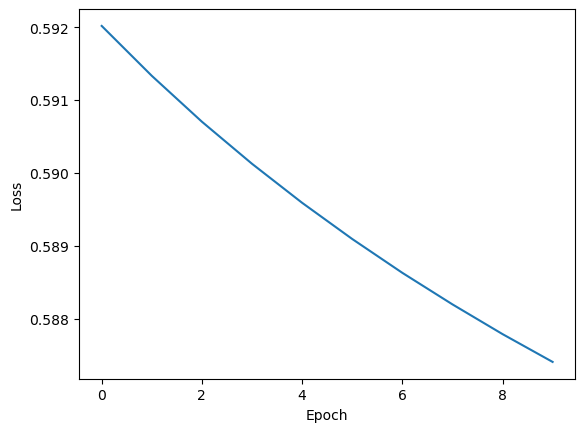

In [99]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [116]:
emb = model(torch.arange(len(vocab))).detach().numpy()

# Normalize the embeddings
emb = np.einsum("ij,i->ij", emb, 1 / np.linalg.norm(emb, axis=1))

### Let's find the most similar words to "cosette"


In [135]:
# Find the vector for Cosette
query = emb[word_to_int["cosette"]]

# Similarity score
scores = query @ emb.T

# Find the most similar words
for i in np.argsort(scores)[::-1][:15]:
    print(f"{int_to_word[i]} (Similarity: {scores[i]:.2f})")

jean (Similarity: 1.00)
valjean (Similarity: 0.95)
marius (Similarity: 0.74)
valjeans (Similarity: 0.69)
fauchelevent (Similarity: 0.67)
maam (Similarity: 0.65)
cosette (Similarity: 0.61)
javert (Similarity: 0.60)
gillenormand (Similarity: 0.60)
madeleine (Similarity: 0.58)
grantaire (Similarity: 0.57)
latter (Similarity: 0.57)
favourite (Similarity: 0.56)
monsieur (Similarity: 0.56)
he (Similarity: 0.56)


### Let's find the most similar words to "jean"


In [136]:
# Find the vector for Cosette
query = emb[word_to_int["jean"]]

# Similarity score
scores = query @ emb.T

# Find the most similar words
for i in np.argsort(scores)[::-1][:15]:
    print(f"{int_to_word[i]} (Similarity: {scores[i]:.2f})")

jean (Similarity: 1.00)
valjean (Similarity: 0.95)
marius (Similarity: 0.74)
valjeans (Similarity: 0.69)
fauchelevent (Similarity: 0.67)
maam (Similarity: 0.65)
cosette (Similarity: 0.61)
javert (Similarity: 0.60)
gillenormand (Similarity: 0.60)
madeleine (Similarity: 0.58)
grantaire (Similarity: 0.57)
latter (Similarity: 0.57)
favourite (Similarity: 0.56)
monsieur (Similarity: 0.56)
he (Similarity: 0.56)


# Let's visualize the embeddings of the less miserable characters. 


In [148]:
les_miserables_characters = [
    "myriel",
    "napoleon",
    "mllebaptistine",
    "mmemagloire",
    "countessdelo",
    "geborand",
    "champtercier",
    "cravatte",
    "labarre",
    "jean",
    "marguerite",
    "mmeder",
    "isabeau",
    "gervais",
    "tholomyes",
    "listolier",
    "fameuil",
    "blacheville",
    "favourite",
    "dahlia",
    "zephine",
    "fantine",
    "mmethenardier",
    "thenardier",
    "cosette",
    "javert",
    "fauchelevent",
    "bamatabois",
    "perpetue",
    "simplice",
    "scaufflaire",
    "judge",
    "champmathieu",
    "brevet",
    "chenildieu",
    "cochepaille",
    "pontmercy",
    "boulatruelle",
    "eponine",
    "anzelma",
    "motherinnocent",
    "gribier",
    "jondrette",
    "mmeburgon",
    "gavroche",
    "gillenormand",
    "magnon",
    "mllegillenormand",
    "mmepontmercy",
    "mllevaubois",
    "ltgillenormand",
    "marius",
    "baronesst",
    "mabeuf",
    "enjolras",
    "combeferre",
    "prouvaire",
    "feuilly",
    "courfeyrac",
    "bahorel",
    "bossuet",
    "joly",
    "grantaire",
    "motherplutarch",
    "gueulemer",
    "babet",
    "claquesous",
    "montparnasse",
    "toussaint",
    "brujon",
    "mmehucheloup",
]
# Filter out characters that are not in the vocabulary
vocab_set = set(vocab)
characters = [c for c in les_miserables_characters if c in vocab_set]
emb_characters = emb[np.array([word_to_int[c] for c in characters])]

/home/skojaku/miniforge3/envs/applsoftcomp/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2.4763651728630065, 6.546776449680328, -1.9734178900718689, 4.467538726329804)

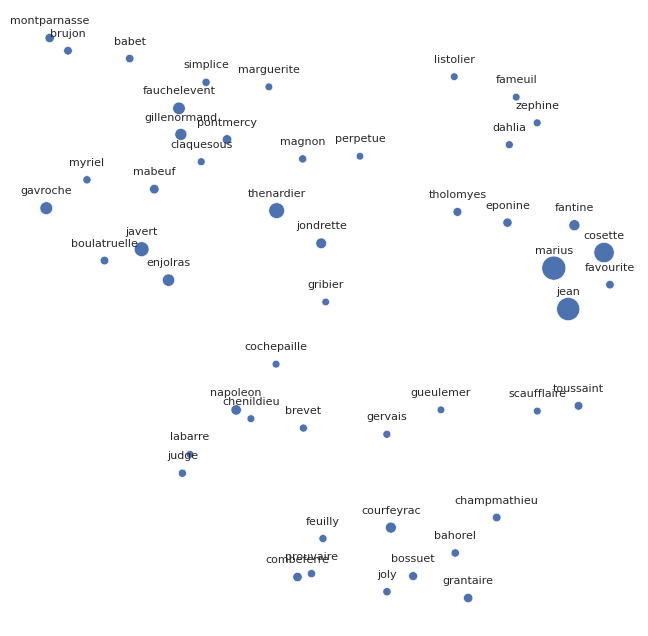

In [155]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt


# Reduce dimensionality
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, metric="cosine")
xy = reducer.fit_transform(emb_characters)


# Plot the characters
character_count = np.array([word_counts.get(c) for c in characters])
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
plt.figure(figsize=(8, 8))

character_size = character_count
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], size=character_size, sizes=(30, 300))
for i, c in enumerate(characters):
    plt.annotate(
        c,
        (xy[i, 0], xy[i, 1]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
    )
plt.legend().remove()
plt.axis("off")